In [1]:
from utils.dataloader import QM9Dataset, DataLoader
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
from scipy.special import softmax
from sklearn.metrics import log_loss
from tqdm import tqdm
import torch
from layers.octetRule import OctetRuleModel
from torch.nn import CrossEntropyLoss

In [2]:
d = QM9Dataset(data='data/zinc/adjacency_matrix_train_scaffold.pkl',num_masks=0)
dl = DataLoader(d,batch_size=100)

In [3]:
all_atoms = {'atom':[],'length':[]}
for b in iter(dl):
    for atoms, length in zip(b.atoms, b.lengths):
        length = length.item()
        
        for atom in atoms:
                all_atoms['atom'] += [atom]
                all_atoms['length'] += [length]
df = pd.DataFrame.from_dict(all_atoms)

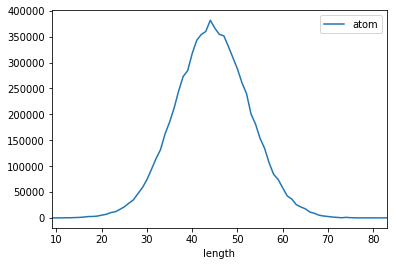

In [4]:
df.groupby('length').count().plot()

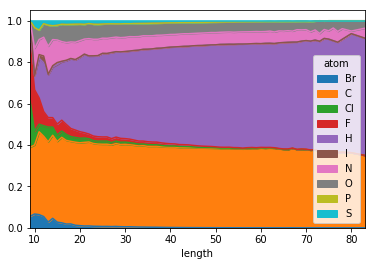

In [5]:
df['c']=1
df3 = df.groupby(['atom','length']).count().reset_index().pivot(index='length',columns='atom',values='c')
df3.div(df3.sum(axis=1), axis=0).plot.area()

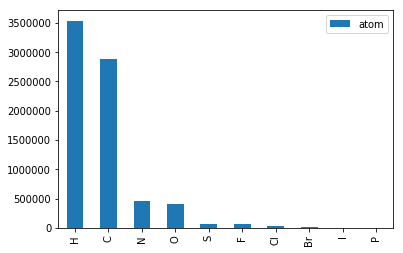

In [6]:
counts = pd.DataFrame(df['atom'].value_counts())
counts.plot(kind='bar')
#make sure the order of the atoms is the same as in the dataloader
counts['srt_val'] = [1,2,4,3,7,5,8,9,10,6]
counts = counts.sort_values('srt_val')['atom']

In [7]:
counts/counts.sum()

H     0.474075
C     0.386910
O     0.054162
N     0.061088
F     0.008556
P     0.000012
S     0.009130
Cl    0.004520
Br    0.001440
I     0.000107
Name: atom, dtype: float64

In [8]:
def inverse_softmax(p):

    result = least_squares(lambda x: softmax(x)-p,[0]*len(p),xtol=1e-15,gtol=1e-15,ftol=1e-15)
    return result.x

In [9]:
softmax(inverse_softmax([0.8,0.2]))

array([0.8, 0.2])

In [10]:
# Unigram
inverse_softmax(list(counts/counts.sum()))

array([ 8.22866764,  8.02549384,  6.05928785,  6.17961773,  4.21389658,
       -2.35038199,  4.27881979,  3.57592162,  2.43191108, -0.16308305])

In [16]:
#Oktet rule unigram with 1 smoothing
atom_groups = [['H','F','Cl','Br','I'],['O','S'],['N','P'],['C']]

octet_counts = []
for i, atom_group in enumerate(atom_groups):
    tmp = counts.copy()
    tmp[~tmp.index.isin(atom_group)] = 0
    octet_counts += [list(tmp)]
    tmp += 1
    print(f"\nGROUP {i+1} : \n")
    print((tmp/tmp.sum()))
    print("\ninverse softmax:")
    print(inverse_softmax(tmp/tmp.sum()))
    print("\nsanity check:")
    print(softmax(inverse_softmax(tmp/tmp.sum())))
    
np.asarray(octet_counts)


GROUP 1 : 

H     9.700741e-01
C     2.742454e-07
O     2.742454e-07
N     2.742454e-07
F     1.750728e-02
P     2.742454e-07
S     2.742454e-07
Cl    9.250298e-03
Br    2.946767e-03
I     2.202191e-04
Name: atom, dtype: float64

inverse softmax:
[15.62359591  0.54473633  0.54473633  0.54473633 11.60884023  0.54473633
  0.54473633 10.97087926  9.82693214  7.23309104]

sanity check:
[9.70074065e-01 2.74245421e-07 2.74245421e-07 2.74245421e-07
 1.75072792e-02 2.74245421e-07 2.74245421e-07 9.25029804e-03
 2.94676704e-03 2.20219073e-04]

GROUP 2 : 

H     0.000002
C     0.000002
O     0.855739
N     0.000002
F     0.000002
P     0.000002
S     0.144244
Cl    0.000002
Br    0.000002
I     0.000002
Name: atom, dtype: float64

inverse softmax:
[-0.51536451 -0.51536451 12.39411748 -0.51536451 -0.51536451 -0.51536451
 10.61366163 -0.51536451 -0.51536451 -0.51536451]

sanity check:
[2.11750456e-06 2.11750456e-06 8.55738649e-01 2.11750456e-06
 2.11750456e-06 2.11750456e-06 1.44244411e-01 2.11750

array([[3537247,       0,       0,       0,   63837,       0,       0,
          33729,   10744,     802],
       [      0,       0,  404125,       0,       0,       0,   68119,
              0,       0,       0],
       [      0,       0,       0,  455800,       0,      90,       0,
              0,       0,       0],
       [      0, 2886876,       0,       0,       0,       0,       0,
              0,       0,       0]])

In [17]:
loss_func = CrossEntropyLoss()

d = QM9Dataset(data='data/zinc/adjacency_matrix_validation_scaffold.pkl',num_masks=100)
dl = DataLoader(d,batch_size=1028)

losses = []
for k in tqdm(np.logspace(0,4)):
    model = OctetRuleModel(k=k)
    loss = []
    for b in dl:
        with torch.no_grad():
            output = model(b)

            targets = b.targets_num 
            targets = targets[targets != 0]
            targets -= 1

            loss += [loss_func(output['out'][b.target_mask], targets).item()]
    losses.append(np.mean(loss))

100%|██████████| 50/50 [13:34<00:00, 16.24s/it]


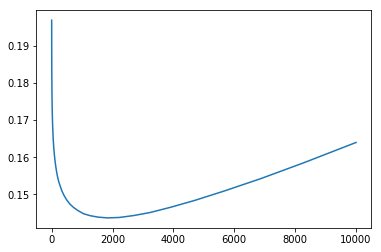

In [20]:
plt.plot(np.logspace(0,4),losses)

In [19]:
np.logspace(0,4)[np.argmin(losses)]

1842.0699693267145